<a href="https://colab.research.google.com/github/mismatchgit/PyTorch-tutorial-freecodecamp/blob/main/Pytorch_classification_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Make Classification data & get it ready

In [1]:
import sklearn
from sklearn.datasets import make_circles
#Make 1000 samples
n_samples = 1000
#create circles
X, y = make_circles(n_samples,
                    noise = 0.03,                                              random_state=42)
len(X), len(y)

(1000, 1000)

In [2]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [3]:
# Make dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


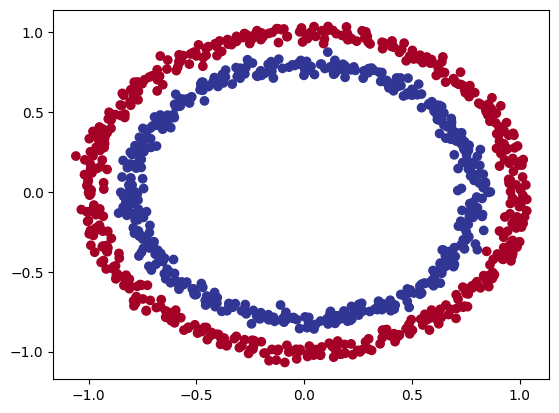

In [4]:
#Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

## Check Input and Output Shapes

In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
#view the first example of features and labels
X_sample = X[0]
y_sample = y[0]

X_sample, y_sample

(array([0.75424625, 0.23148074]), np.int64(1))

In [7]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

## Turn Data into Tensors and create train and test splits

In [8]:
import torch
#Turn data into tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)
X.dtype, y.dtype

(torch.float32, torch.float32)

In [9]:
#Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state = 42)
len(X_train),len(y_test)

(800, 200)

 ## Building a model to classify blue and red dot

In [10]:
from torch import nn
#device agnostic code
device ="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [11]:
 #construct a model that subclasses nn.Module
 class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    #create 2 nn.Linear layers capable of handling the data
    self.layer_1 = nn.Linear(in_features =2, out_features =5)
    self.layer_2 = nn.Linear (in_features=5, out_features =1)
  #Define a forward method
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) #x goes into layer 1 then to layer 2 and then output

#instantiate an instance of our model class and send it to target device
model_0 = CircleModelV0()
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
#send parameters to device(cpu or GPU)
next(model_0.parameters()).device

device(type='cpu')

In [13]:
#for visualizing the model above go to playground.tensorflow.org
#similar model but implemented with nn.sequential()
model_0n = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0n

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
# the sequential can be used in the nn.Module subclass also like below
class CircleModelSequential():
  def __init__(self):
    super().__init__()
    #2 layers using sequential instead of manually defining each layer
    self.two_linear_layers = nn.Sequential(
        nn.Linear(in_features=2, out_features=5),
        nn.Linear(in_features=5, out_features=1)
    )
  #override the forward method
  def forward(self, x):
    return self.two_linear_layers(x)

In [15]:
model_0n.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.4462,  0.3584],
                      [-0.2459, -0.6131],
                      [ 0.5039,  0.2810],
                      [-0.0905, -0.2058],
                      [-0.4180, -0.3337]])),
             ('0.bias', tensor([-0.2224, -0.5254, -0.6610, -0.0428,  0.1469])),
             ('1.weight',
              tensor([[-0.2344, -0.4458, -0.0689, -0.0246,  0.0778]])),
             ('1.bias', tensor([-0.1172]))])

In [16]:
#Make predictions without train
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length : {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"\nLength of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 Untrained Prediction: {untrained_preds[:10]}")
print(f"\nFirst 10 True Result or labels: {y_test[:10]}")

Length : 200, Shape: torch.Size([200, 1])

Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 Untrained Prediction: tensor([[-0.4121],
        [-0.3995],
        [-0.3926],
        [-0.4178],
        [-0.3093],
        [-0.3022],
        [-0.3328],
        [-0.3098],
        [-0.3962],
        [-0.3977]])

First 10 True Result or labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [17]:
# setting p loss function and optimizer

loss_function = nn.BCEWithLogitsLoss()#BCELoss() can also be used. But it requires inputs to have gone through the sigmoid activation function prior to input to BCELoss. BCEWithLogitLoss has sigmoid activation function built-in

#nn.BCEWithLogitsLoss() is similar to the following
# nn.Sequential(
#     nn.Sigmoid(),
#     nn.BCELoss()
# )

optimizer = torch.optim.SGD(params=model_0n.parameters(),
                            lr= 0.01)

In [18]:
#calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = ((correct/len(y_pred))*100)
  return acc

Our model outputs are going to be raw logits.

We can convert these logits into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to prediction labels by either rounding them or taking the argmax().

In [19]:
#Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)
#view first 5 output from the forward pass
model_0n.eval()
with torch.inference_mode():
  y_logits= model_0n(X_test.to(device))[:5]

y_logits

tensor([[0.3514],
        [0.3694],
        [0.2224],
        [0.3883],
        [0.0922]])

In [20]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [21]:
#use the sigmoid activation function on logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5870],
        [0.5913],
        [0.5554],
        [0.5959],
        [0.5230]])

In [22]:
y_pred_probs = torch.nn.Sigmoid(y_logits)
y_pred_probs

TypeError: Sigmoid.__init__() takes 1 positional argument but 2 were given

In [23]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([False, False, False, False, False])


tensor([1., 1., 1., 1., 1.])

In [24]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [25]:
#Building a training and testing loop
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
    # 2. Calculate loss/accuracy
    # loss = loss_function(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_function(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_function(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70979, Accuracy: 50.00% | Test loss: 0.70973, Test acc: 50.00%
Epoch: 10 | Loss: 0.70979, Accuracy: 50.00% | Test loss: 0.70973, Test acc: 50.00%
Epoch: 20 | Loss: 0.70979, Accuracy: 50.00% | Test loss: 0.70973, Test acc: 50.00%
Epoch: 30 | Loss: 0.70979, Accuracy: 50.00% | Test loss: 0.70973, Test acc: 50.00%
Epoch: 40 | Loss: 0.70979, Accuracy: 50.00% | Test loss: 0.70973, Test acc: 50.00%
Epoch: 50 | Loss: 0.70979, Accuracy: 50.00% | Test loss: 0.70973, Test acc: 50.00%
Epoch: 60 | Loss: 0.70979, Accuracy: 50.00% | Test loss: 0.70973, Test acc: 50.00%
Epoch: 70 | Loss: 0.70979, Accuracy: 50.00% | Test loss: 0.70973, Test acc: 50.00%
Epoch: 80 | Loss: 0.70979, Accuracy: 50.00% | Test loss: 0.70973, Test acc: 50.00%
Epoch: 90 | Loss: 0.70979, Accuracy: 50.00% | Test loss: 0.70973, Test acc: 50.00%


In [26]:
#Implementation of plot decision boundary by hand
def plot_decision_boundary_by_hand(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


In [27]:
#or the same can be done with the following method (downloading from others github repo)
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)



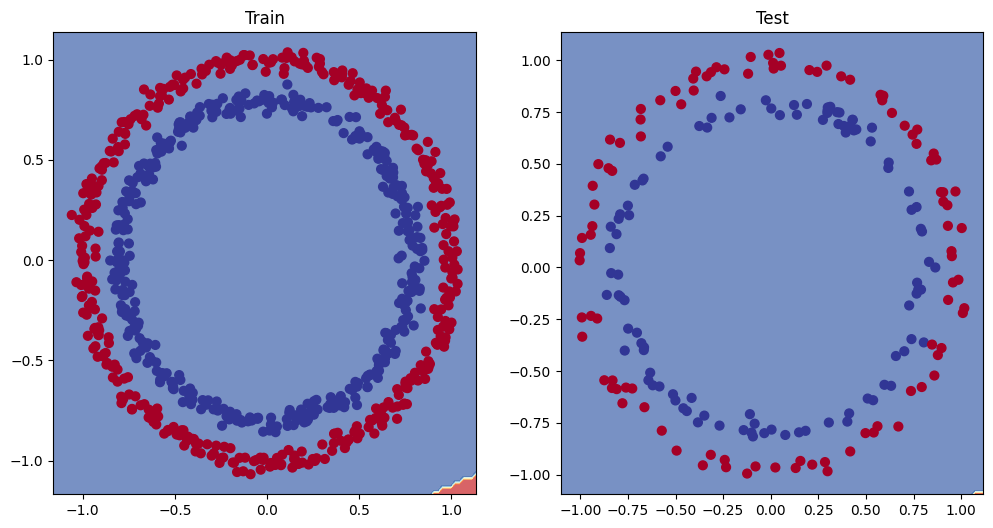

In [28]:
from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0n, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0n, X_test, y_test)

### Improving a model (from a model perspective)
Add more layers - give the model more chances to learn about patterns in the data
Add more hidden units - go from 5 hidden units to 10 hidden units
Fit for longer
Changing the activation functions
Change the learning rate
Change the loss function

In [29]:
# Let's try and improve our model by:

# Adding more hidden units: 5 -> 10
# Increase the number of layers: 2 -> 3
# Increase the number of epochs: 100 -> 1000

# Create a model
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages speed ups where possible behind the scenes

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [30]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [31]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()
  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probabilities -> prediction labels

  # 2. Calculate the loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Calculate loss
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print out what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Acc: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Acc: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%


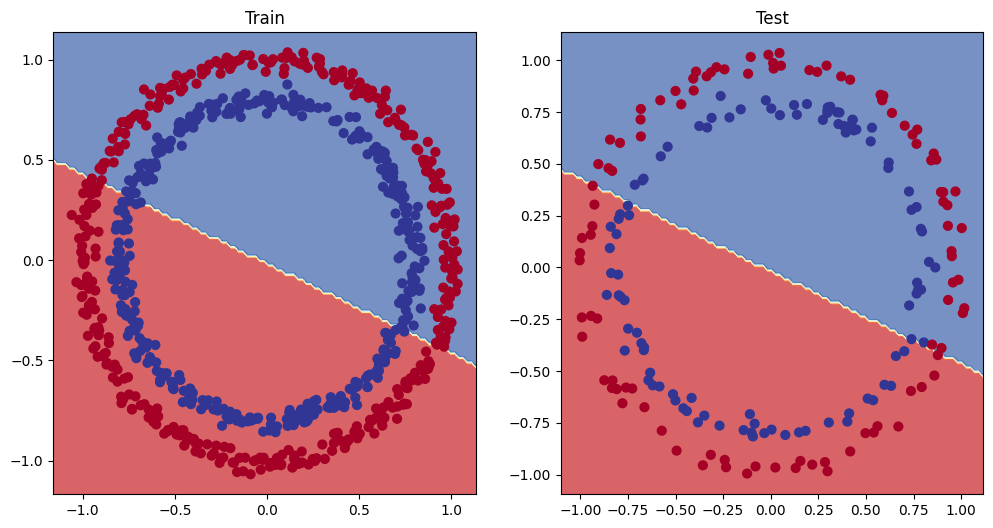

In [32]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)



## 6. The missing piece: non-linearity

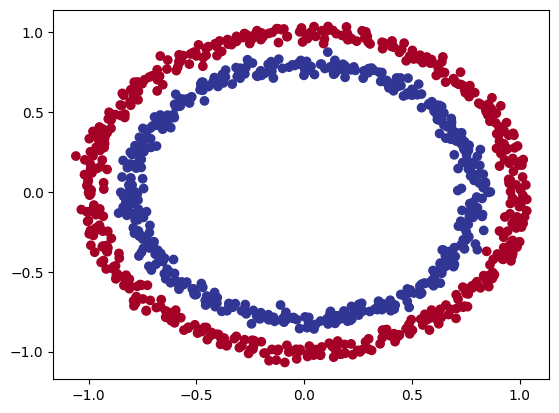

In [33]:
# Recreating non-linear data (red and blue circles)

# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [34]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [40]:
#Building a model with non-linearity

# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=32)
    self.layer_2 = nn.Linear(in_features=32, out_features=32)
    self.layer_3 = nn.Linear(in_features=32, out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function

  def forward(self, x):
    # Where should we put our non-linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [41]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)

In [42]:
#Training a model with non-linearity
#random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

#loop through data
epochs =1000

for epoch in range(epochs):
  #training
  model_3.train()

  #forwardpass
  y_logits = model_3(X_train).squeeze()
  #logits to pred probabilty to pred labels
  y_pred = torch.round(torch.sigmoid(y_logits))

  #calculate the loss
  loss = loss_fn(y_logits, y_train) #BCEWithLLogits take logits as first input
  accuracy = accuracy_fn(y_true = y_train,
                         y_pred=y_pred)#This time train first as scikit-learn uses

  #optimizaer zero grad
  optimizer.zero_grad()

  #loss backward
  loss.backward()

  #step tthe optimizer
  optimizer.step()

  #testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test,test_pred)

  if epoch%100 ==0:
    print(f"Epoch:{epoch} | Loss: {loss:.4f}, Acc:{accuracy:.2f}| Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch:0 | Loss: 0.6947, Acc:46.88| Test Loss: 0.6944, Test Acc: 47.00%
Epoch:100 | Loss: 0.6896, Acc:58.13| Test Loss: 0.6896, Test Acc: 58.50%
Epoch:200 | Loss: 0.6838, Acc:66.00| Test Loss: 0.6844, Test Acc: 64.50%
Epoch:300 | Loss: 0.6743, Acc:73.12| Test Loss: 0.6762, Test Acc: 77.50%
Epoch:400 | Loss: 0.6554, Acc:81.38| Test Loss: 0.6595, Test Acc: 81.50%
Epoch:500 | Loss: 0.6152, Acc:94.75| Test Loss: 0.6243, Test Acc: 91.50%
Epoch:600 | Loss: 0.5298, Acc:99.50| Test Loss: 0.5470, Test Acc: 99.00%
Epoch:700 | Loss: 0.3772, Acc:99.75| Test Loss: 0.4058, Test Acc: 99.00%
Epoch:800 | Loss: 0.2172, Acc:99.88| Test Loss: 0.2538, Test Acc: 99.50%
Epoch:900 | Loss: 0.1208, Acc:99.88| Test Loss: 0.1568, Test Acc: 99.50%


In [43]:
#Evaluating a model trained with non-linear activation functions
# Makes predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]



(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

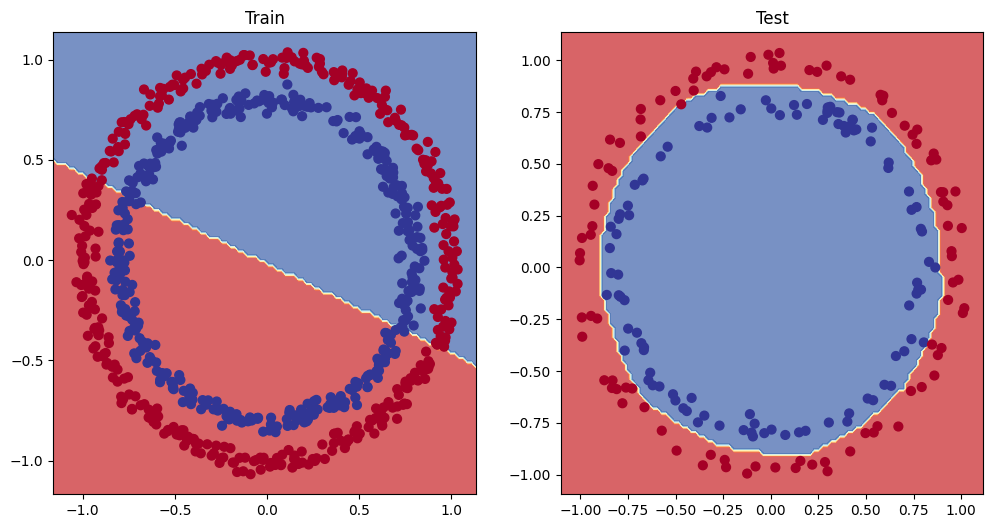

In [44]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

## Multiclass Classification

### creating dataset

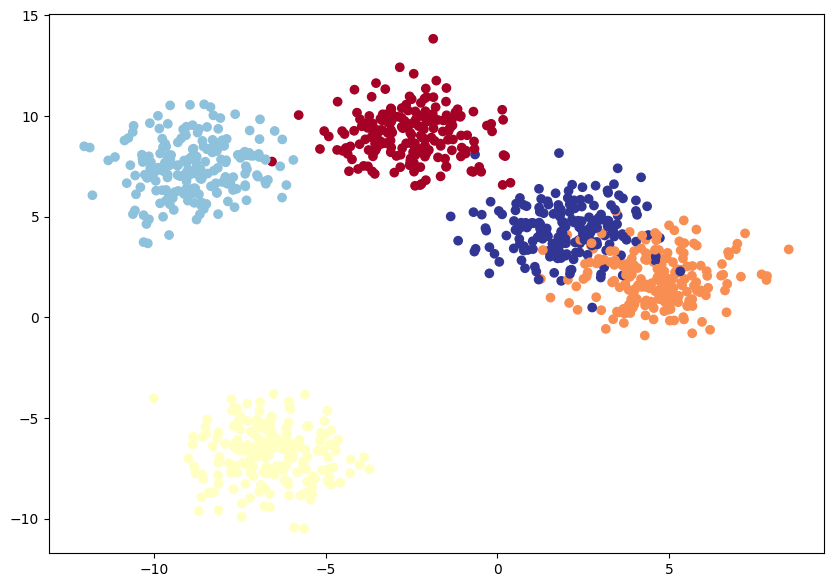

In [48]:
#import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 5
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.25, # give the clusters a little shake up
                            random_state=RANDOM_SEED)


# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data (visualize, visualize, visualize)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

###building the model

In [49]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [53]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes multi-class classification model.

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of outputs features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8

    Returns:

    Example:
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2,
                    output_features=5,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=5, bias=True)
  )
)

In [54]:

# Create a loss function for multi-class classification - loss function measures how wrong our model's predictions are
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification - optimizer updates our model parameters to try and reduce the loss
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1) # learning rate is a hyperparameter you can change

In [55]:
# Let's get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]


tensor([[-0.6473, -2.0725,  0.4245, -1.6282,  0.6913],
        [ 0.3614, -0.6846, -0.2779,  0.1496, -0.2066],
        [ 0.3120, -0.8423, -0.2452,  0.0346, -0.1687],
        [-1.2000, -0.1040,  0.8604, -1.7556,  1.3684],
        [-0.4411, -2.0677,  0.2756, -1.3513,  0.4888],
        [-1.3690, -2.4540,  0.9385, -2.7105,  1.3751],
        [-0.2591, -1.3734,  0.1572, -0.8928,  0.3569],
        [ 0.6907, -0.4209, -0.5108,  0.6712, -0.5125],
        [-0.9832, -0.5228,  0.6960, -1.5959,  1.1267],
        [ 0.5515, -0.4887, -0.4115,  0.4643, -0.3802]])

In [56]:

# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.6473, -2.0725,  0.4245, -1.6282,  0.6913],
        [ 0.3614, -0.6846, -0.2779,  0.1496, -0.2066],
        [ 0.3120, -0.8423, -0.2452,  0.0346, -0.1687],
        [-1.2000, -0.1040,  0.8604, -1.7556,  1.3684],
        [-0.4411, -2.0677,  0.2756, -1.3513,  0.4888]])
tensor([[0.1198, 0.0288, 0.3498, 0.0449, 0.4567],
        [0.3072, 0.1079, 0.1621, 0.2486, 0.1741],
        [0.3063, 0.0966, 0.1755, 0.2322, 0.1894],
        [0.0393, 0.1175, 0.3083, 0.0225, 0.5124],
        [0.1618, 0.0318, 0.3313, 0.0651, 0.4100]])


In [57]:

# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([4, 0, 0, 4, 4, 4, 4, 0, 4, 0, 4, 4, 0, 4, 4, 0, 4, 4, 4, 4, 0, 4, 4, 0,
        4, 4, 4, 0, 0, 4, 4, 4, 0, 4, 4, 4, 0, 0, 0, 4, 4, 4, 0, 0, 0, 4, 0, 4,
        4, 4, 0, 4, 0, 0, 4, 0, 4, 4, 4, 4, 0, 4, 4, 0, 4, 0, 4, 0, 4, 0, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 0, 4, 4, 4, 0, 4, 4, 4, 4, 4,
        4, 4, 0, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 0, 0, 4, 0, 0,
        4, 0, 0, 0, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 4,
        4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 0, 0, 4, 4, 0,
        0, 4, 4, 0, 4, 4, 4, 0, 0, 4, 4, 0, 0, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4,
        4, 0, 0, 0, 4, 4, 4, 0])

In [58]:
y_blob_test

tensor([0, 1, 1, 2, 0, 3, 4, 1, 2, 1, 0, 3, 1, 2, 2, 4, 4, 0, 3, 2, 1, 4, 3, 1,
        0, 3, 4, 1, 1, 2, 2, 3, 4, 3, 2, 0, 1, 4, 1, 0, 3, 0, 4, 1, 4, 0, 4, 2,
        2, 2, 1, 2, 4, 4, 2, 1, 4, 4, 2, 0, 4, 0, 3, 1, 2, 4, 2, 1, 3, 4, 2, 3,
        2, 2, 3, 0, 2, 0, 2, 0, 2, 3, 4, 3, 1, 0, 1, 0, 0, 2, 1, 2, 0, 3, 3, 3,
        3, 0, 4, 2, 4, 3, 0, 3, 0, 0, 0, 3, 0, 2, 2, 3, 1, 4, 0, 4, 4, 2, 1, 1,
        3, 1, 4, 1, 0, 4, 4, 2, 3, 4, 2, 4, 3, 0, 2, 0, 2, 2, 1, 1, 3, 2, 2, 2,
        3, 1, 4, 2, 0, 0, 2, 3, 0, 4, 2, 3, 3, 2, 1, 0, 0, 3, 2, 4, 4, 0, 0, 1,
        4, 3, 1, 4, 0, 0, 3, 4, 4, 0, 4, 4, 1, 3, 2, 2, 2, 4, 0, 2, 0, 3, 2, 3,
        2, 1, 4, 1, 0, 4, 4, 1])

In [59]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
  ### Training
  model_4.train()

  #forward pass
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  #loss function and accuracy
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  #opitimizer zero grad
  optimizer.zero_grad()

  #loss backward
  loss.backward()

  #step step step
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)

  # Print out what's happenin'
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 2.2982, Acc: 6.88% | Test loss: 1.2070, Test acc: 29.50%
Epoch: 10 | Loss: 0.8127, Acc: 49.75% | Test loss: 0.7360, Test acc: 70.00%
Epoch: 20 | Loss: 0.4008, Acc: 90.38% | Test loss: 0.3881, Test acc: 93.00%
Epoch: 30 | Loss: 0.2648, Acc: 94.62% | Test loss: 0.2587, Test acc: 95.00%
Epoch: 40 | Loss: 0.2064, Acc: 94.62% | Test loss: 0.2031, Test acc: 95.00%
Epoch: 50 | Loss: 0.1774, Acc: 94.75% | Test loss: 0.1752, Test acc: 95.00%
Epoch: 60 | Loss: 0.1615, Acc: 94.62% | Test loss: 0.1597, Test acc: 95.00%
Epoch: 70 | Loss: 0.1520, Acc: 94.50% | Test loss: 0.1503, Test acc: 95.00%
Epoch: 80 | Loss: 0.1458, Acc: 94.62% | Test loss: 0.1441, Test acc: 95.00%
Epoch: 90 | Loss: 0.1417, Acc: 94.62% | Test loss: 0.1398, Test acc: 95.00%


In [60]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  7.1879, -16.2196,  -6.6562,   2.9862,   0.9362],
        [  2.5045,  11.0699,  -7.7639,  -5.6585,   9.2685],
        [  3.3477,   9.5664,  -8.5860,  -5.3873,   9.4667],
        [ -8.9142, -26.1009,  20.6046,  12.3543, -22.0717],
        [  8.1392, -11.1586,  -9.6081,   0.7452,   4.5256],
        [  6.3558, -34.6081,   0.1086,  10.2090,  -9.1576],
        [  4.2574,  -5.4089,  -5.4724,  -0.0615,   3.0294],
        [  2.2707,  19.6264,  -9.9745,  -8.8017,  13.2678],
        [ -5.0152, -21.5667,  13.3621,   9.2787, -15.4338],
        [  2.0709,  16.0912,  -8.6139,  -7.3992,  11.2825]])

In [61]:
# Go from logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[9.8338e-01, 6.7141e-11, 9.5571e-07, 1.4722e-02, 1.8952e-03],
        [1.6357e-04, 8.5818e-01, 5.6776e-09, 4.6618e-08, 1.4166e-01],
        [1.0444e-03, 5.2436e-01, 6.8565e-09, 1.6799e-07, 4.7460e-01],
        [1.5137e-13, 5.1990e-21, 9.9974e-01, 2.6110e-04, 2.9229e-19],
        [9.7317e-01, 4.0479e-09, 1.9081e-08, 5.9840e-04, 2.6231e-02],
        [2.0770e-02, 3.3654e-20, 4.0208e-05, 9.7919e-01, 3.8024e-09],
        [7.6552e-01, 4.8520e-05, 4.5533e-05, 1.0192e-02, 2.2420e-01],
        [2.8958e-08, 9.9827e-01, 1.3923e-13, 4.4986e-13, 1.7288e-03],
        [1.0269e-08, 6.6582e-16, 9.8343e-01, 1.6570e-02, 3.0676e-13],
        [8.0817e-07, 9.9191e-01, 1.8501e-11, 6.2333e-11, 8.0923e-03]])

In [62]:
# Go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([0, 1, 1, 2, 0, 3, 0, 1, 2, 1])

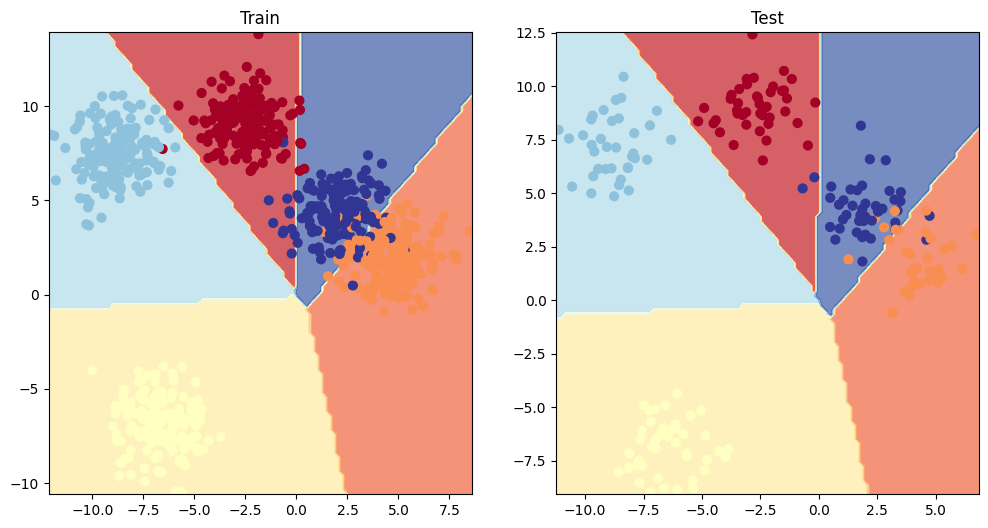

In [63]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

'''9. A few more classification metrics... (to evaluate our classification model)
Accuracy - out of 100 samples, how many does our model get right?



Precision
Recall
F1-score
Confusion matrix
Classification report'''